<a href="https://colab.research.google.com/github/jmachima/VisionTransformer_vs_CNN_on_Bees_n_Wasps/blob/main/ViT_vs_CNN_bee_or_wasp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jasmine Machima 

jasmine.machima@gmail.com

Comparison of image classification models: Vision Transformer vs. Convolutional Neural Network

Data set: Bee or Wasp (https://www.kaggle.com/jerzydziewierz/bee-vs-wasp) from Kaggles

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
from PIL import Image
import pathlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

In [2]:
tf.__version__  # using Colab

'2.7.0'

In [ ]:
# Set up a TPU environment (faster than using GPU)

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

In [4]:
!mkdir stingers

# Prepare a separate directory

In [6]:
os.getcwd() 
os.chdir('stingers') 
# Change the working directory to 'stingers' so that the files go there directly

In [ ]:
from google.colab import files
files.upload() # upload BEE.zip and WASP.zip

In [ ]:
!unzip BEE.zip
!unzip WASP.zip
!rm BEE.zip
!rm WASP.zip
# Delete the zip files afterwards

In [9]:
os.chdir('/content/') 

# Return to the main directory for Colab user

In [10]:
# Function to extract images


def extractpix(directory):
  image_set = []
  label_set = []
  # get the image paths inside the directory
  
  category = []
  
  count = 0
  
  for dirc in sorted(os.listdir(directory)):
    print(dirc)
    category.append(str(dirc))
    for img_path in os.listdir(directory+'/'+str(dirc)):
      im = Image.open(directory+'/'+str(dirc)+'/'+str(img_path))
      image_set.append(np.array(im))
      label_set.append(count)
      # when finished with the first directory, the label for the second directory changes
    
    
    count += 1
    
  image_set = np.array(image_set)
  label_set = np.array(label_set)
  category = dict(zip(set(label_set),category))
  return image_set, label_set, category

In [11]:
image_set, label_set, category = extractpix('stingers')


BEE
WASP


In [ ]:
from google.colab import files
files.upload()   #get flowers.zip


In [ ]:
!unzip flower.zip
external_set, ex_label, ex_category = extractpix('flower') # bring in images of wasps on flowers NOT USED IN TRAIN/VAL/TEST data sets

In [14]:
num_classes = 2
input_shape = (160, 160, 3)

X_train, X_dev_test, y_train, y_dev_test = train_test_split(image_set, label_set, test_size=0.3, random_state=39)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test, y_dev_test, test_size=0.5, random_state=97)
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_dev shape: {X_dev.shape} - y_dev shape: {y_dev.shape}")

x_train shape: (3312, 160, 160, 3) - y_train shape: (3312,)
x_dev shape: (710, 160, 160, 3) - y_dev shape: (710,)


## Vision Transformer Model for training 
Adapted from https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [15]:
# Accelerate the training process with TPUs (Tensor Processing Units) 

with strategy.scope():
    learning_rate = 0.000085
    batch_size = 64
    num_epochs = 20
    image_size = 160  
    patch_size = 10  # Size of the patches to be extract from the input images
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 300
    num_heads = 8   # of separate transformer heads
    transformer_units = [
        projection_dim * 2,
        projection_dim]  # output dimension of multilayer perceptrons in a transformer unit
    
    # Number of successive transformer layers
    transformer_layers = 16
    mlp_head_units = [2048, 1024]  # output dimensions of dense layers before the final layer
    
    # Setting up an input processing layer
    data_adaptation = layers.Normalization()

    data_adaptation.adapt(X_train)
    # Adapt the above normalization layer to the mean and the variance of the training data for future normalization.
    # X_train itself has not been changed here

    # Defining Multi-layer perceptrons (mlp) layers
    def mlp(x, hidden_units, dropout_rate):
      for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
      return x

    class Patches(layers.Layer):
      def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

      def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    
    class PatchEncoder(layers.Layer):
      def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

      def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)  # each patch needs info on its position within the image
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    

    def TransformerBlock(X):
          # Layer normalization 1
      Xn1 = layers.LayerNormalization(epsilon=1e-7)(X)
          # Use a multi-head attention layer.
      attention_output = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=projection_dim, dropout=0.1
      )(Xn1, Xn1)
          # Skip connection 1.
      Xatt_res = layers.Add()([attention_output, X])
          # Layer normalization 2.
      Xn2 = layers.LayerNormalization(epsilon=1e-7)(Xatt_res)
          # MLP.
      Xmlp = mlp(Xn2, hidden_units=transformer_units, dropout_rate=0.1)
          # Skip connection 2.
      encoded_patches = layers.Add()([Xmlp, Xn2])
      return encoded_patches


    def vit_model():
      inputs = layers.Input(shape=input_shape)
      
      adapted = data_adaptation(inputs)
      
      # Create patches.
      patches = Patches(patch_size)(adapted)
      # Encode patches.
      encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

      # Create multiple layers of the Transformer block.

      for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(encoded_patches)
      
      encoded_patches = layers.LayerNormalization(epsilon=1e-7)(encoded_patches)
      patch_F = layers.Flatten()(encoded_patches)
      patch_F = layers.Dropout(0.1)(patch_F)  
      # Add MLP.
      features = mlp(patch_F, hidden_units=mlp_head_units, dropout_rate=0.1)
      # Classify outputs.
      logits = layers.Dense(num_classes)(features)
      # Create the Keras model.
      model = keras.Model(inputs=inputs, outputs=logits)
      return model

    vit_classifier = vit_model()

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate, epsilon = 1e-7)

    vit_classifier.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"))
              
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=13)  # when preferred

    history_vit =  vit_classifier.fit(
          x=X_train,
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_split=0.0, validation_data=(X_dev,y_dev)) #,
          #callbacks=callback)
          

Epoch 1/20
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


52/52 [==============================] - 177s 2s/step - loss: 1.0144 - accuracy: 0.7017 - val_loss: 0.6649 - val_accuracy: 0.7620
Epoch 2/20
52/52 [==============================] - 10s 200ms/step - loss: 0.4057 - accuracy: 0.8394 - val_loss: 0.3820 - val_accuracy: 0.8310
Epoch 3/20
52/52 [==============================] - 10s 201ms/step - loss: 0.2500 - accuracy: 0.8986 - val_loss: 0.5660 - val_accuracy: 0.8028
Epoch 4/20
52/52 [==============================] - 10s 201ms/step - loss: 0.1543 - accuracy: 0.9378 - val_loss: 0.5325 - val_accuracy: 0.8493
Epoch 5/20
52/52 [==============================] - 10s 201ms/step - loss: 0.1035 - accuracy: 0.9614 - val_loss: 0.4343 - val_accuracy: 0.8648
Epoch 6/20
52/52 [==============================] - 10s 200ms/step - loss: 0.0543 - accuracy: 0.9810 - val_loss: 0.5782 - val_accuracy: 0.8408
Epoch 7/20
52/52 [==============================] - 10s 201ms/step - loss: 0.0513 - accuracy: 0.9819 - val_loss: 0.6950 - val_accuracy: 0.8141
Epoch 8/20
5

In [16]:
# Evaluating the trained ViT model on the test data set

Pred = vit_classifier.predict(X_test)

Prediction = np.argmax(Pred, axis = 1) # predicted category

confusion = metrics.confusion_matrix(y_test, Prediction)
print("Confusion Matrix:\n",confusion,"\n")

accuracy = metrics.accuracy_score(y_test, Prediction)
print("Test Accuracy:", round(accuracy*100,1),'%')

print(metrics.classification_report(y_test, Prediction, digits=3))

Confusion Matrix:
 [[335  30]
 [ 55 290]] 

Test Accuracy: 88.0 %
              precision    recall  f1-score   support

           0      0.859     0.918     0.887       365
           1      0.906     0.841     0.872       345

    accuracy                          0.880       710
   macro avg      0.883     0.879     0.880       710
weighted avg      0.882     0.880     0.880       710



Image size: 160 X 160
Patch size: 10 X 10
Patches per image: 256
Elements per patch: 300


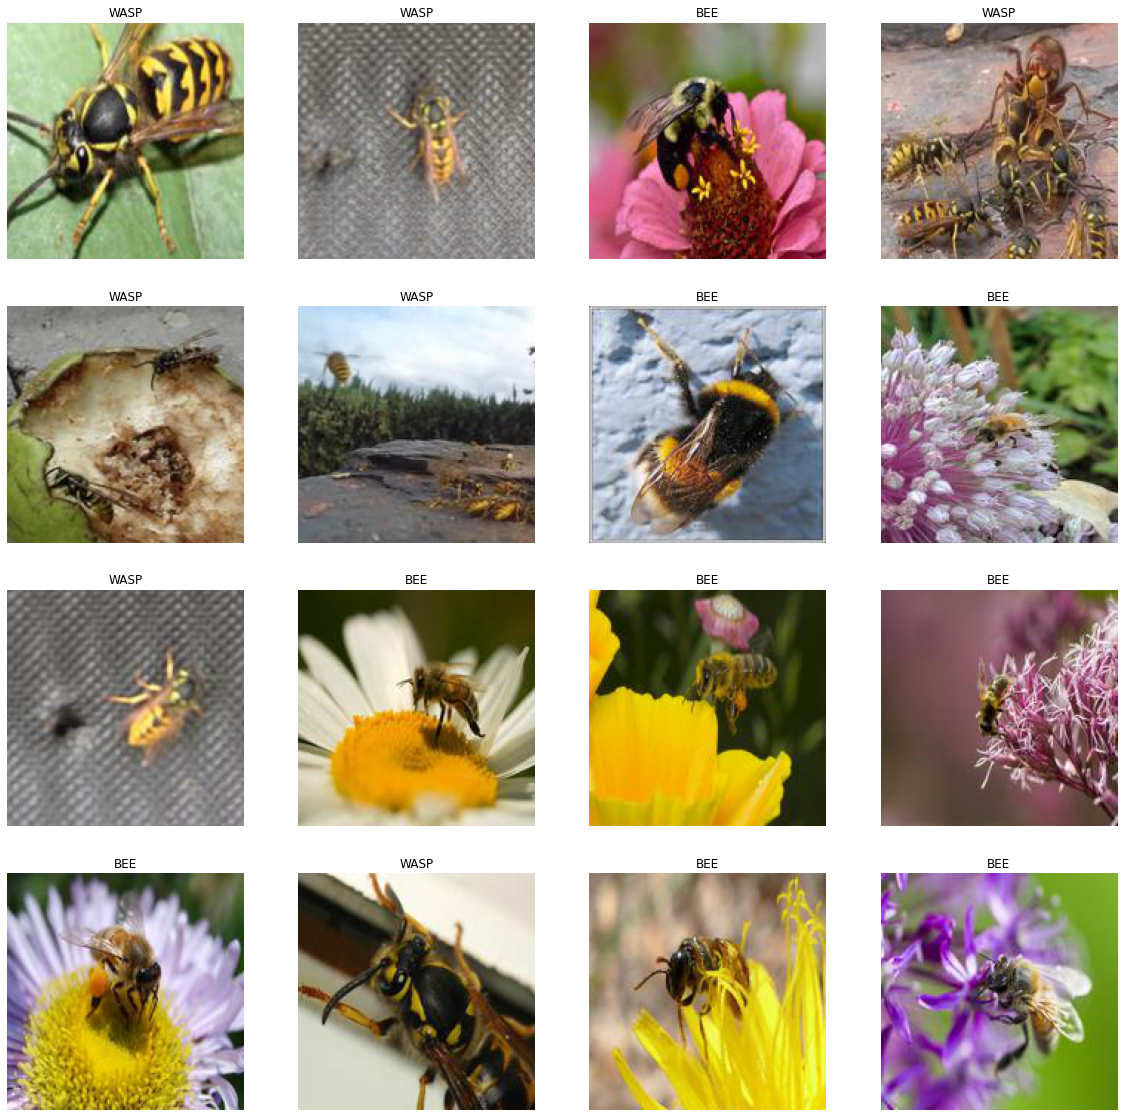

In [19]:
ch = np.random.randint(0, 710, size=16)
plt.figure(figsize=(20, 20))
for i in range(len(ch)):
  AX = plt.subplot(4, 4, i + 1)
  img = X_dev[ch[i]]
  img_label = category[y_dev[ch[i]]]
  plt.xlabel(img_label)
  plt.imshow(img)    #.astype("uint8"))
  plt.title(img_label)
  plt.axis("off")


Example image broken into individual patches 

Image size: 160 X 160
Patch size: 10 X 10
Patches per image: 256
Elements per patch: 300


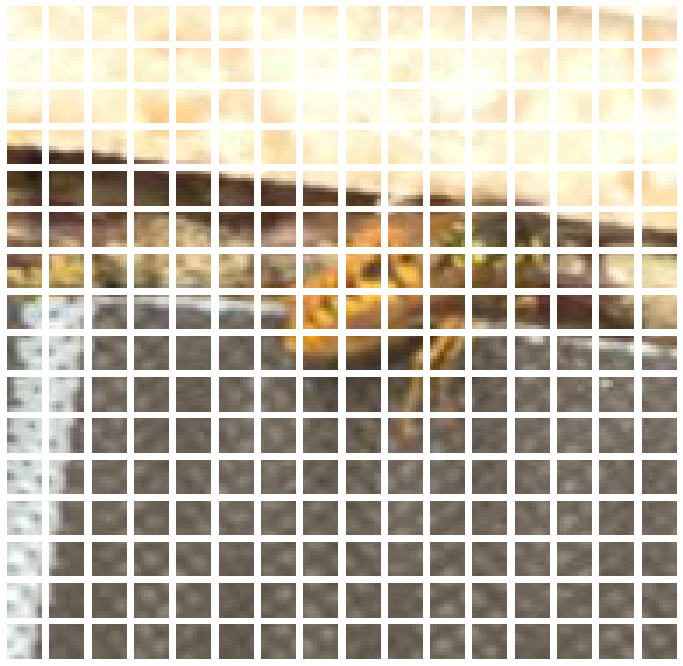

In [33]:
print('Example image broken into individual patches \n')

image = X_dev[np.random.randint(0, 710)]
patches = Patches(patch_size)(tf.convert_to_tensor([image])) 

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(12, 12))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())   #.astype("uint8"))
    plt.axis("off")

In [28]:
# Most bees are found on flowers. Let's check the model on wasps on flowers

Ex_Pred = vit_classifier.predict(external_set)

Ex_Prediction = np.argmax(Ex_Pred, axis = 1) 

Ex_confusion = metrics.confusion_matrix(ex_label, Ex_Prediction)
print("Confusion Matrix:\n",Ex_confusion,"\n")

Ex_accuracy = metrics.accuracy_score(ex_label, Ex_Prediction)
print("External Test Accuracy:", round(Ex_accuracy*100,1),'%')


Confusion Matrix:
 [[ 0  0]
 [26  1]] 

External Test Accuracy: 3.7 %


The trained ViT model cannot correctly predict the wasp class on a background commonly found with bees

# Training with Convolutional Neural Network (CNN) 



In [22]:
# input shape for the CNN model
INPUT_SHAPE = (160, 160, 3)

# Convert list of rgb arrays into tensors

Xtr = tf.convert_to_tensor(X_train)
Xdv = tf.convert_to_tensor(X_dev)
Xtst = tf.convert_to_tensor(X_test)

# Using One Hot Encoder to transform 0 into [1,0] and 1 into [0,1]
OH = OneHotEncoder()

def OHT(y_train):
  y = np.reshape(y_train, (-1,1))
  y = OH.fit_transform(y).toarray()
  y = tf.convert_to_tensor(y, dtype=tf.int32)
  return y

# Transform the y arrays
Ytr, Ydv, Ytst = [OHT(y_train) for y_train in [y_train, y_dev, y_test]]



In [23]:
# With CNN, the training does not need TPUs. With only CPU or GPU, the training can progress at a reasonable speed.

#Each layer of convolution needs to be followed by Batch Normalization, Max Pooling, and Dropout, 
#which can be group together in an appropriate sequence.
def NormMaxDrop(dropout):
  LayerGrp = tf.keras.Sequential(
                [layers.BatchNormalization(axis=-1),
                 layers.MaxPooling2D(pool_size=(2, 2)),
                 layers.Dropout(dropout)]
  )
  return LayerGrp

NMD_1, NMD_2, NMD_3, NMD_4 = [NormMaxDrop(0.1) for _ in range(4)]

def CNN_MODEL():

    model = tf.keras.models.Sequential()
    input_shape = INPUT_SHAPE

    model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(NMD_1) 
    
    model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(NMD_2) 
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(NMD_3) 

    model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(NMD_4) 
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(320, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

Model = CNN_MODEL()

EPOCHS = 12
opt = tf.keras.optimizers.Adam(learning_rate=0.0004)
Model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history_CNN = Model.fit(Xtr, Ytr, epochs=EPOCHS, validation_data=(Xdv, Ydv))

Epoch 1/12
104/104 [==============================] - 14s 125ms/step - loss: 0.5434 - accuracy: 0.8056 - val_loss: 0.3726 - val_accuracy: 0.8507
Epoch 2/12
104/104 [==============================] - 13s 124ms/step - loss: 0.3040 - accuracy: 0.8747 - val_loss: 0.4062 - val_accuracy: 0.8521
Epoch 3/12
104/104 [==============================] - 13s 123ms/step - loss: 0.2476 - accuracy: 0.9049 - val_loss: 0.3303 - val_accuracy: 0.8634
Epoch 4/12
104/104 [==============================] - 13s 124ms/step - loss: 0.2248 - accuracy: 0.9061 - val_loss: 0.3612 - val_accuracy: 0.8535
Epoch 5/12
104/104 [==============================] - 13s 125ms/step - loss: 0.1674 - accuracy: 0.9369 - val_loss: 0.3011 - val_accuracy: 0.8901
Epoch 6/12
104/104 [==============================] - 13s 125ms/step - loss: 0.1423 - accuracy: 0.9441 - val_loss: 0.3251 - val_accuracy: 0.8845
Epoch 7/12
104/104 [==============================] - 13s 126ms/step - loss: 0.1182 - accuracy: 0.9538 - val_loss: 0.3090 - val_ac

In [27]:
#Testing the CNN Model on the test data set.

pred = Model.predict(Xtst)

prediction = np.argmax(pred, axis = 1) # predicted category

Confusion = metrics.confusion_matrix(y_test, prediction)
print("Confusion Matrix:\n",Confusion,"\n")

Accuracy = metrics.accuracy_score(y_test, prediction)
print("Test Accuracy:", round(Accuracy*100,1),'%')

print(metrics.classification_report(y_test, prediction, digits=3))

Confusion Matrix:
 [[331  34]
 [ 37 308]] 

Test Accuracy: 90.0 %
              precision    recall  f1-score   support

           0      0.899     0.907     0.903       365
           1      0.901     0.893     0.897       345

    accuracy                          0.900       710
   macro avg      0.900     0.900     0.900       710
weighted avg      0.900     0.900     0.900       710



External Test Accuracy: 18.5 %

 Confusion Matrix:
 [[ 0  0]
 [22  5]] 



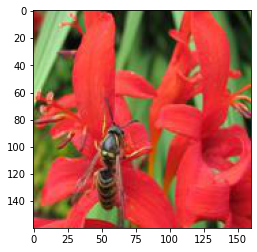

BEE: 97.4 %  WASP: 2.6 %


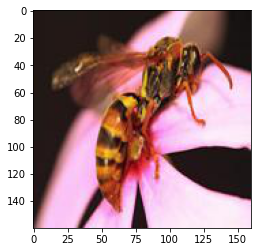

BEE: 99.9 %  WASP: 0.1 %


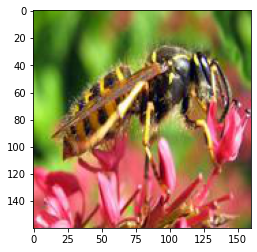

BEE: 99.1 %  WASP: 0.9 %


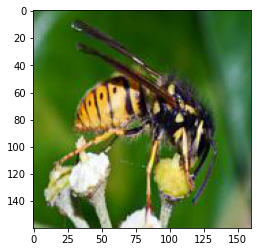

BEE: 49.6 %  WASP: 50.4 %


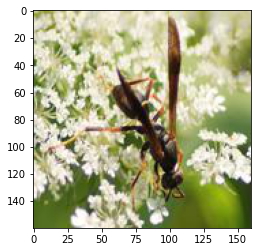

BEE: 90.8 %  WASP: 9.2 %


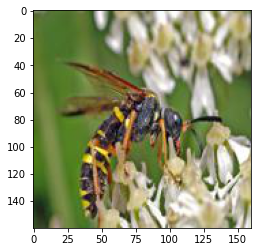

BEE: 99.7 %  WASP: 0.3 %


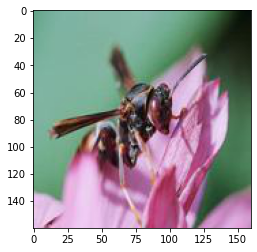

BEE: 99.4 %  WASP: 0.6 %


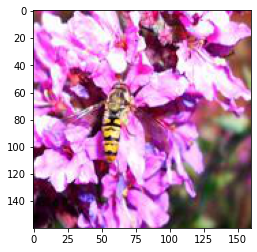

BEE: 100.0 %  WASP: 0.0 %


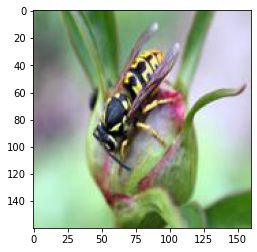

BEE: 96.1 %  WASP: 3.9 %


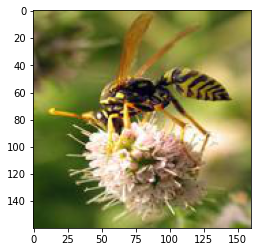

BEE: 80.1 %  WASP: 19.9 %


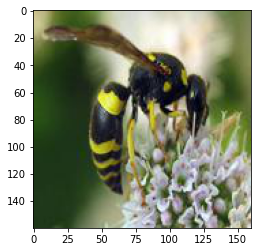

BEE: 15.6 %  WASP: 84.4 %


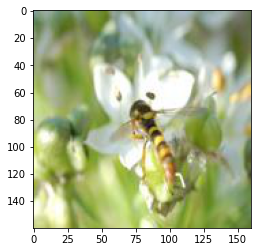

BEE: 4.3 %  WASP: 95.7 %


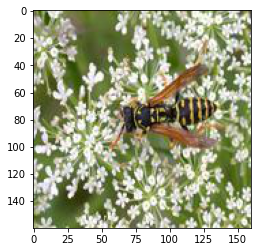

BEE: 62.6 %  WASP: 37.4 %


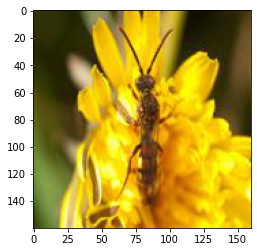

BEE: 100.0 %  WASP: 0.0 %


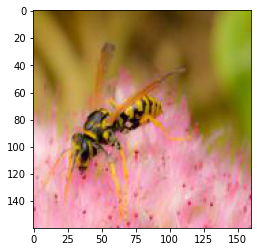

BEE: 76.4 %  WASP: 23.6 %


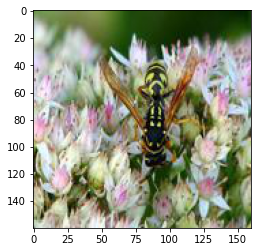

BEE: 82.8 %  WASP: 17.2 %


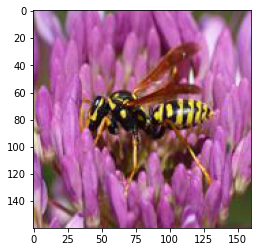

BEE: 100.0 %  WASP: 0.0 %


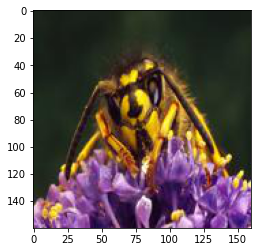

BEE: 86.5 %  WASP: 13.5 %


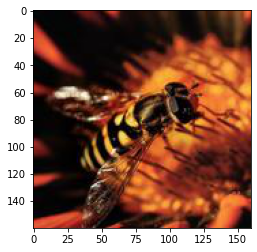

BEE: 43.6 %  WASP: 56.4 %


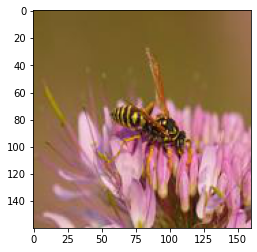

BEE: 99.9 %  WASP: 0.1 %


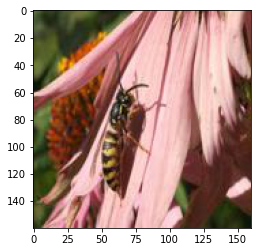

BEE: 100.0 %  WASP: 0.0 %


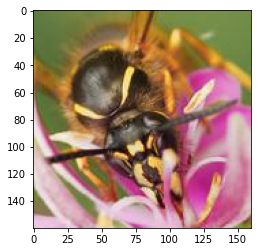

BEE: 94.5 %  WASP: 5.5 %


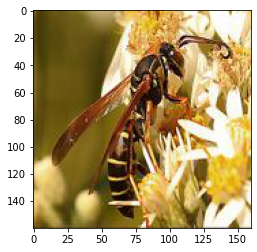

BEE: 93.9 %  WASP: 6.1 %


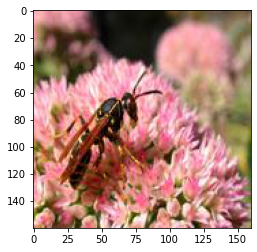

BEE: 100.0 %  WASP: 0.0 %


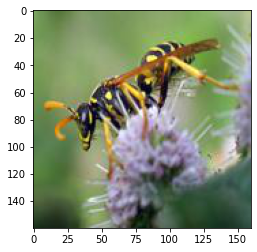

BEE: 30.0 %  WASP: 70.0 %


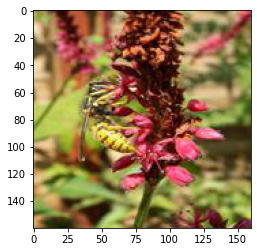

BEE: 99.6 %  WASP: 0.4 %


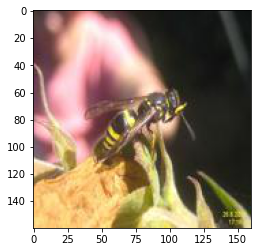

BEE: 91.7 %  WASP: 8.3 %


In [29]:
ExTest = tf.convert_to_tensor(external_set)

Y_ex = [1]*len(ExTest)

ex_pred = Model.predict(ExTest)
ex_pred = ex_pred*100

ex_prediction = np.argmax(ex_pred, axis = 1) 

ex_accuracy = metrics.accuracy_score(ex_label, ex_prediction)
print("External Test Accuracy:", round(ex_accuracy*100,1),'%')

ex_confusion = metrics.confusion_matrix(ex_label, ex_prediction)
print('\n',"Confusion Matrix:\n",ex_confusion,"\n")
for i in range(len(external_set)):
    plt.imshow(external_set[i])
    plt.show()
    print("BEE:", round(ex_pred[i][0],1),"% ","WASP:", round(ex_pred[i][1],1),"%")

CNN model has the same wasp on flower issue as the ViT model.

Vision Transformer may be more accurate and more efficient than CNN with other image sets but, for two image classes which are very similar to each other, CNN gives a comparable result if not better. In this case, CNN is also much faster as it does not require TPUs.